# EDA on weather data

In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

In [2]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [6]:
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 57.01,
	"longitude": 9.99,
	"start_date": "2024-04-01",
	"end_date": "2024-04-30",
	"hourly": ["temperature_2m", "precipitation", "rain", "snowfall", "snow_depth"],
	"timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)

In [7]:
print(responses)

In [12]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["snow_depth"] = hourly_snow_depth

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates 56.977149963378906°N 10.0632905960083°E
Elevation 23.0 m asl
Timezone b'Europe/Berlin' b'CEST'
Timezone difference to GMT+0 7200 s
                         date  temperature_2m  precipitation  rain  snowfall  \
0   2024-03-31 22:00:00+00:00        3.830500            0.0   0.0       0.0   
1   2024-03-31 23:00:00+00:00        5.180500            0.0   0.0       0.0   
2   2024-04-01 00:00:00+00:00        5.530500            0.0   0.0       0.0   
3   2024-04-01 01:00:00+00:00        4.880500            0.0   0.0       0.0   
4   2024-04-01 02:00:00+00:00        4.730500            0.0   0.0       0.0   
..                        ...             ...            ...   ...       ...   
715 2024-04-30 17:00:00+00:00       15.080501            0.0   0.0       0.0   
716 2024-04-30 18:00:00+00:00       14.180500            0.0   0.0       0.0   
717 2024-04-30 19:00:00+00:00       13.330501            0.0   0.0       0.0   
718 2024-04-30 20:00:00+00:00       13.130500            

In [13]:
hourly_dataframe.describe()

,temperature_2m,precipitation,rain,snowfall,snow_depth
count,720.000000,720.000000,720.000000,720.000000,720.000000
mean,7.229180,0.135000,0.130139,0.003403,0.001389
std,4.096645,0.428696,0.420966,0.030811,0.004446
min,-2.569500,0.000000,0.000000,0.000000,0.000000
25%,4.268000,0.000000,0.000000,0.000000,0.000000
50%,7.230500,0.000000,0.000000,0.000000,0.000000
75%,9.680500,0.025000,0.025000,0.000000,0.000000
max,18.030499,4.600000,4.600000,0.420000,0.030000


<Axes: xlabel='date'>

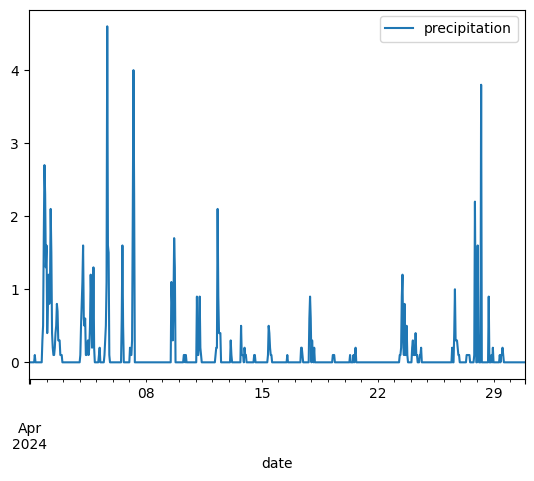

In [14]:
df_water = pd.DataFrame(hourly_dataframe, columns = ['date', 'precipitation'])
df_water = df_water.set_index('date')
df_water.plot()

In [18]:
df_water['above_1mm'] = df_water['precipitation'] > 1

In [19]:
df_water

,precipitation,above_1mm
date,,
2024-03-31 22:00:00+00:00,0.0,False
2024-03-31 23:00:00+00:00,0.0,False
2024-04-01 00:00:00+00:00,0.0,False
2024-04-01 01:00:00+00:00,0.0,False
2024-04-01 02:00:00+00:00,0.0,False
...,...,...
2024-04-30 17:00:00+00:00,0.0,False
2024-04-30 18:00:00+00:00,0.0,False
2024-04-30 19:00:00+00:00,0.0,False


In [20]:
df_water_and_temp = pd.DataFrame(hourly_dataframe, columns = ['date', 'temperature_2m', 'precipitation'])

In [21]:
df_water_and_temp = df_water_and_temp.set_index('date')

In [22]:
df_water_and_temp

,temperature_2m,precipitation
date,,
2024-03-31 22:00:00+00:00,3.830500,0.0
2024-03-31 23:00:00+00:00,5.180500,0.0
2024-04-01 00:00:00+00:00,5.530500,0.0
2024-04-01 01:00:00+00:00,4.880500,0.0
2024-04-01 02:00:00+00:00,4.730500,0.0
...,...,...
2024-04-30 17:00:00+00:00,15.080501,0.0
2024-04-30 18:00:00+00:00,14.180500,0.0
2024-04-30 19:00:00+00:00,13.330501,0.0
